In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pytz import timezone as tz

In [3]:
from time import time
from datetime import date
from datetime import datetime

In [4]:
# Measure performance:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
df_energy = pd.read_csv('../data/'+ "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"]).sort_values(by=["Région", "Date - Heure"])

In [6]:
df_energy = df_energy[["Région", "Date - Heure", "Consommation (MW)"]]

In [7]:
df_energy.fillna(df_energy.dropna()["Consommation (MW)"].mean(), inplace=True)

In [8]:
df_energy.isnull().sum()

Région               0
Date - Heure         0
Consommation (MW)    0
dtype: int64

In [9]:
df_energy.dtypes

Région                object
Date - Heure          object
Consommation (MW)    float64
dtype: object

In [10]:
df_energy.fillna(df_energy.dropna()["Consommation (MW)"].mean(), inplace=True)
df_energy["date"] = df_energy["Date - Heure"].apply(lambda x: x + timedelta(minutes=x.minute))
df_energy["date"] = df_energy["date"].apply(lambda x: x.astimezone(tz("UTC")))
df_energy["date"] = df_energy["date"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df_energy.head(3)

,Région,Date - Heure,Consommation (MW),date
147167,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
147170,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
1017843,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00


In [11]:
df_energy.head()

,Région,Date - Heure,Consommation (MW),date
147167,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,4528.493194,2013-01-01 00:00:00
147170,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.000000,2013-01-01 01:00:00
1017843,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.000000,2013-01-01 01:00:00
147173,Auvergne-Rhône-Alpes,2013-01-01 01:30:00+01:00,7896.000000,2013-01-01 02:00:00
1017845,Auvergne-Rhône-Alpes,2013-01-01 02:00:00+01:00,7882.000000,2013-01-01 02:00:00


In [12]:
# group by day:
df_region_per_hour = df_energy.groupby(["Région", "date"], as_index=False).agg({"Consommation (MW)": np.sum})

In [13]:
df_region_per_hour.head()

,Région,date,Consommation (MW)
0,Auvergne-Rhône-Alpes,2013-01-01 00:00:00,4528.493194
1,Auvergne-Rhône-Alpes,2013-01-01 01:00:00,16117.000000
2,Auvergne-Rhône-Alpes,2013-01-01 02:00:00,15778.000000
3,Auvergne-Rhône-Alpes,2013-01-01 03:00:00,15618.000000
4,Auvergne-Rhône-Alpes,2013-01-01 04:00:00,14944.000000


In [14]:
df_region_per_hour.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
dtype: object

# Filter on Ile de France

In [15]:
df_region_per_hour_ile_de_france = df_region_per_hour[df_region_per_hour['Région']=='Ile-de-France']

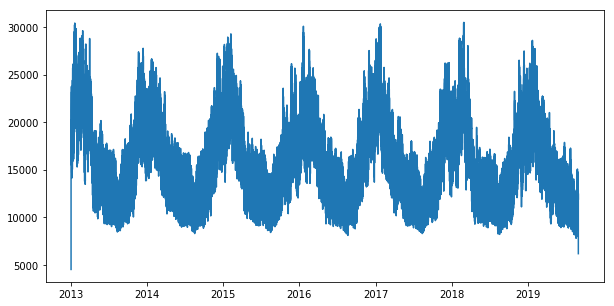

In [16]:
plt.figure(figsize=(10,5))
plt.plot(df_region_per_hour_ile_de_france["date"], df_region_per_hour_ile_de_france["Consommation (MW)"])

In [17]:
#restraindre la durée

In [18]:
df_region_per_hour_ile_de_france_small = df_region_per_hour_ile_de_france[(df_region_per_hour_ile_de_france['date']>='2017-01-01 00:00:00')&(df_region_per_hour_ile_de_france['date']<'2019-01-15 00:00:00')]




In [19]:
df_region_per_hour_ile_de_france_small.to_csv('../data/ile_de_france_dataset.csv')

# Prophet for forcasting Ile de France energy

In [20]:
df_region_per_hour_ile_de_france_small.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
dtype: object

In [21]:
df_region_per_hour_ile_de_france_small.head()

,Région,date,Consommation (MW)
385520,Ile-de-France,2017-01-01 00:00:00,24147.0
385521,Ile-de-France,2017-01-01 01:00:00,23337.0
385522,Ile-de-France,2017-01-01 02:00:00,22179.0
385523,Ile-de-France,2017-01-01 03:00:00,21433.0
385524,Ile-de-France,2017-01-01 04:00:00,20597.0


In [22]:
df_region_per_hour_ile_de_france_small['date_time']=pd.to_datetime(df_region_per_hour_ile_de_france_small['date'], format='%Y-%m-%d')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df_region_per_hour_ile_de_france_small.head()

,Région,date,Consommation (MW),date_time
385520,Ile-de-France,2017-01-01 00:00:00,24147.0,2017-01-01 00:00:00
385521,Ile-de-France,2017-01-01 01:00:00,23337.0,2017-01-01 01:00:00
385522,Ile-de-France,2017-01-01 02:00:00,22179.0,2017-01-01 02:00:00
385523,Ile-de-France,2017-01-01 03:00:00,21433.0,2017-01-01 03:00:00
385524,Ile-de-France,2017-01-01 04:00:00,20597.0,2017-01-01 04:00:00


In [24]:
df_region_per_hour_ile_de_france_small.dtypes

Région                       object
date                 datetime64[ns]
Consommation (MW)           float64
date_time            datetime64[ns]
dtype: object

In [25]:
# Select training set:
df_region_per_hour_ile_de_france_small_train = df_region_per_hour_ile_de_france_small[(df_region_per_hour_ile_de_france_small['date_time']<='2018-12-31 23:00:00')&(df_region_per_hour_ile_de_france_small['date_time']>='2018-12-01 00:00:00')]



In [26]:
df_region_per_hour_ile_de_france_small_train.head()

,Région,date,Consommation (MW),date_time
402294,Ile-de-France,2018-12-01 00:00:00,18490.0,2018-12-01 00:00:00
402295,Ile-de-France,2018-12-01 01:00:00,17163.0,2018-12-01 01:00:00
402296,Ile-de-France,2018-12-01 02:00:00,15562.0,2018-12-01 02:00:00
402297,Ile-de-France,2018-12-01 03:00:00,14980.0,2018-12-01 03:00:00
402298,Ile-de-France,2018-12-01 04:00:00,14473.0,2018-12-01 04:00:00


In [27]:
df_region_per_hour_ile_de_france_small_train.tail()

,Région,date,Consommation (MW),date_time
403033,Ile-de-France,2018-12-31 19:00:00,20763.0,2018-12-31 19:00:00
403034,Ile-de-France,2018-12-31 20:00:00,20236.0,2018-12-31 20:00:00
403035,Ile-de-France,2018-12-31 21:00:00,18923.0,2018-12-31 21:00:00
403036,Ile-de-France,2018-12-31 22:00:00,17614.0,2018-12-31 22:00:00
403037,Ile-de-France,2018-12-31 23:00:00,18173.0,2018-12-31 23:00:00


In [28]:
model_energy = Prophet(interval_width=0.9)


In [29]:
df_region_per_hour_ile_de_france_small_train.rename(columns={"date_time": "ds"}, inplace=True)
df_region_per_hour_ile_de_france_small_train.rename(columns={"Consommation (MW)": "y"}, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
df_prophet_train = df_region_per_hour_ile_de_france_small_train[['ds','y']]

In [31]:
df_prophet_train.head()

,ds,y
402294,2018-12-01 00:00:00,18490.0
402295,2018-12-01 01:00:00,17163.0
402296,2018-12-01 02:00:00,15562.0
402297,2018-12-01 03:00:00,14980.0
402298,2018-12-01 04:00:00,14473.0


In [32]:
df_prophet_train.count()

ds    744
y     744
dtype: int64

In [33]:
# It takes me 45 min to train a model  over 5 years !

In [34]:
start_time = time()
model_energy.fit(df_prophet_train)
end_time = time()
print ("This model took %.2f seconds to train" % (end_time - start_time))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



This model took 0.96 seconds to train


In [35]:
future_ile_de_france_energy_date_2019 = model_energy.make_future_dataframe(periods=3*24,freq='H', include_history = False)


In [36]:
future_ile_de_france_energy_date_2019.head(100)

,ds
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00
5,2019-01-01 05:00:00
6,2019-01-01 06:00:00
7,2019-01-01 07:00:00
8,2019-01-01 08:00:00
9,2019-01-01 09:00:00


In [37]:
start_time = time()
future_energy_forcast_ile_de_france_2019 = model_energy.predict(future_ile_de_france_energy_date_2019)
end_time = time()
print ("This took %.2f seconds" % (end_time - start_time))

This took 2.92 seconds


In [38]:
future_energy_forcast_ile_de_france_2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].count()

ds            72
yhat          72
yhat_lower    72
yhat_upper    72
dtype: int64

df_region_per_day_ile_de_france_2017_2018.head()

In [39]:
future_energy_forcast_ile_de_france_2019_plot= future_energy_forcast_ile_de_france_2019

In [40]:
df_region_per_hour_ile_de_france_plot=df_region_per_hour_ile_de_france_small

In [41]:
import matplotlib

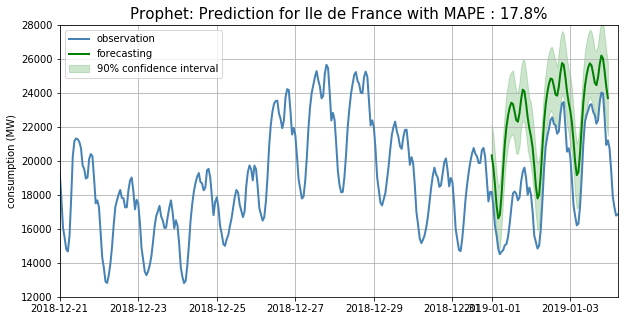

In [51]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5),linewidth=2)
plt.plot(df_region_per_hour_ile_de_france_plot[-600:-258].date,df_region_per_hour_ile_de_france_plot[-600:-258]['Consommation (MW)'],color='steelblue',label='observation',linewidth=2.0)
plt.plot(future_energy_forcast_ile_de_france_2019_plot.ds.dt.to_pydatetime(),future_energy_forcast_ile_de_france_2019_plot.yhat,color='g',label='forecasting',linewidth=2.0)

plt.fill_between(future_energy_forcast_ile_de_france_2019_plot.ds.dt.to_pydatetime(), future_energy_forcast_ile_de_france_2019_plot['yhat_lower'], future_energy_forcast_ile_de_france_2019_plot['yhat_upper'],
                        color='green', alpha=0.2,label='90% confidence interval' )
plt.title('Prophet: Prediction for Ile de France with' + " MAPE : {}%".format(str(round(100*0.17788634, 1))))
plt.grid(which='both')
plt.ylim([12000, 28000])

plt.ylabel("consumption (MW)")
plt.rc('xtick', labelsize=10)  
plt.rc('ytick', labelsize=10)# fontsize of the axes title
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)
plt.margins(0)
plt.legend()


In [52]:
y_true = df_region_per_hour_ile_de_france_small[(df_region_per_hour_ile_de_france_small['date_time'] >= '2019-01-01')&(df_region_per_hour_ile_de_france_small['date_time'] < '2019-01-04')]['Consommation (MW)']


In [53]:
y_true.count()

72

In [54]:
y_pred = future_energy_forcast_ile_de_france_2019['yhat']

In [55]:
y_pred.count()

72

In [56]:
mean_absolute_percentage_error(y_true, y_pred)

17.788634740897177